## Prediction of Gout from patient's Chief Complaint Corpa

### A patient's verbal complaint is recorded by staff with each Emergency Room visit.  This machine learning model predicts if the patient is describing a potential "Gout" attack using local terms and vocabulary, alterting medical staff to this potential disease.  

In [1]:
import pandas as pd
import pickle


import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score

# NLP Libraries

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
#import scispacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy


# ONE-TIME DOWNLOADS
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download()

## Import Data
#### The data is found in the MIMIC-III (Medical Information Mart for Intensive Care III) database.  Details can be found at https://physionet.org/content/emer-complaint-gout/1.0/.   Acces to the database may be requested at (https://mimic.physionet.org/gettingstarted/access/).  The data is contained in 2 csv files from years 2019 and 2020.

In [2]:
syn2019 = pd.read_csv('Data/GOUT-CC-2019-CORPUS-SYNTHETIC.csv')
syn2020 = pd.read_csv('Data/GOUT-CC-2020-CORPUS-SYNTHETIC.csv')

The 3 columns contain the following data:
-  column 0: string text of the patient's chief complaint
-  column 1: string indicator indicating the prediction made by the ER Physician on the possibility of Gout
-  column 2: string indicator indicating the consensus result by the endocrinologist on the diagnosis of Gout

string indicator is a char of Y (yes), N (no), or - (unknown) 

In [3]:
print(syn2019.head())

                                     Chief Complaint Predict Consensus
0  "been feeling bad" last 2 weeks & switched BP ...       N         -
1  "can't walk", reports onset at 0830 am. orient...       Y         N
2  "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y
3  "gout flare up" L arm swelling x 1 week. denie...       Y         Y
4  "heart racing,"dyspnea, and orthopnea that has...       N         -


In [4]:
print(syn2020.head())

                                     Chief Complaint Predict Consensus
0  "I dont know whats going on with my head, its ...       N         -
1  "i've been depressed for a few weeks now, i'm ...       N         -
2  Altercation while making arrest, c/o R hand pa...       N         N
3  Cut on L upper thigh wtih saw. Bleeding contro...       N         N
4   Dysuria x1 week. hx: hysterectomy, gerd, bipolar       N         -


#### We don't have a need to separate years, date does not impact predictive quality so we will combine the files now, making cleaning and analysis easier.

In [5]:
# Combine the files into 1 dataframe
df = pd.concat([syn2019, syn2020], axis=0).reset_index(drop=True)
print(df.shape)

(8437, 3)


In [6]:
print(df.dtypes)

Chief Complaint    object
Predict            object
Consensus          object
dtype: object


In [7]:
print(df['Predict'].value_counts(sort=False))

N    8168
Y     111
U     156
-       2
Name: Predict, dtype: int64


In [8]:
print(df['Consensus'].value_counts(sort=False))

N     350
Y      95
U      16
-    7976
Name: Consensus, dtype: int64


In [9]:
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [10]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(df['Chief Complaint'].apply(round1))
data_clean

,Chief Complaint
0,been feeling bad last weeks switched bp medi...
1,cant walk reports onset at am oriented aorti...
2,dehydration chest hurts hips hurt cramps pmh h...
3,gout flare up l arm swelling x week denies an...
4,heart racingdyspnea and orthopnea that has bee...
...,...
8432,stepped on a nail at home with right foot pain...
8433,i was having a breakdown rt stress and depres...
8434,i tried to jump in front of a car pt states sh...
8435,abdominal pain x week denies pmh


In [11]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [12]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_clean['Chief Complaint'].apply(round2))
data_clean

,Chief Complaint
0,been feeling bad last weeks switched bp medi...
1,cant walk reports onset at am oriented aorti...
2,dehydration chest hurts hips hurt cramps pmh h...
3,gout flare up l arm swelling x week denies an...
4,heart racingdyspnea and orthopnea that has bee...
...,...
8432,stepped on a nail at home with right foot pain...
8433,i was having a breakdown rt stress and depres...
8434,i tried to jump in front of a car pt states sh...
8435,abdominal pain x week denies pmh


In [13]:
# Let's take a look at our dataframe
df

,Chief Complaint,Predict,Consensus
0,"""been feeling bad"" last 2 weeks & switched BP ...",N,-
1,"""can't walk"", reports onset at 0830 am. orient...",Y,N
2,"""dehydration"" Chest hurts, hips hurt, cramps P...",Y,Y
3,"""gout flare up"" L arm swelling x 1 week. denie...",Y,Y
4,"""heart racing,""dyspnea, and orthopnea that has...",N,-
...,...,...,...
8432,"stepped on a nail at home with right foot, pai...",N,N
8433,""" I was having a breakdown."" R/T stress and de...",N,-
8434,"""I tried to jump in front of a car"" Pt states ...",N,-
8435,Abdominal pain x 1 week. Denies PMH,N,-


In [14]:
# Let's pickle it for later use
df.to_pickle("corpus.pkl")

In [15]:
df = df[df['Consensus']!= "-"]
df = df[df['Predict']!= "-"]
df = df[df['Consensus']!= "U"]
df = df[df['Predict']!= "U"]
df.shape

(303, 3)

In [16]:
print(df.dtypes)

Chief Complaint    object
Predict            object
Consensus          object
dtype: object


In [17]:
df['Predict'].value_counts()

N    209
Y     94
Name: Predict, dtype: int64

In [18]:
df['Consensus'].value_counts()

N    223
Y     80
Name: Consensus, dtype: int64

### Remove digits: 
#### the text commonly contains many descriptions such as number of times a patient takes medication, etc and will add noise to the model.  

In [19]:
pattern = r'[0-9]'

In [20]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x: re.sub(pattern, '', x))
print(df.head(20))

                                      Chief Complaint Predict Consensus
1   "can't walk", reports onset at  am. oriented x...       Y         N
2   "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y
3   "gout flare up" L arm swelling x  week. denies...       Y         Y
5   "I started breathing hard"  hx- htn, gout, anx...       N         N
6   "I think I have a gout flare up" L wrist pain ...       Y         Y
7   "I want to see if I have an infection" pt vagu...       Y         N
8   "My gout done flared up on me", c/o R ankle, L...       Y         Y
9   "my gout is hurting me"- reports bilateral foo...       Y         Y
11        "umbearable" right foot/ankle pain pmh gout       Y         Y
12  (LMC) transfer for renal transplant. pt SOB x ...       N         N
14  (JI) dizziness and SOB. recent HTN med change ...       N         N
15  (RM) intermittent cp since this am, worse duri...       N         N
17  (Grandview tx) neck pain and right arm pain fo...       N   

### Tokenize sentences

In [21]:
tokenizer = RegexpTokenizer("[\w']+")

In [22]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Remove stop words

In [23]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [24]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x : remove_stopwords(x))
df['Chief Complaint'].head()
df

,Chief Complaint,Predict,Consensus
1,"[can't, walk, reports, onset, oriented, x, aor...",Y,N
2,"[dehydration, chest, hurts, hips, hurt, cramps...",Y,Y
3,"[gout, flare, l, arm, swelling, x, week, denie...",Y,Y
5,"[started, breathing, hard, hx, htn, gout, anxi...",N,N
6,"[think, gout, flare, l, wrist, pain, swelling,...",Y,Y
...,...,...,...
8424,"[sob, right, chest, pain, x, weeks, hx, multip...",N,N
8425,"[starts, lower, back, goes, right, legs, x, mo...",N,N
8427,"[sciatica, pain, r, lower, back, radiating, r,...",N,N
8432,"[stepped, nail, home, right, foot, painful, di...",N,N


### Perform lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [27]:
df['Chief Complaint'].apply(lambda x: word_lemmatizer(x))

1       [can't, walk, report, onset, oriented, x, aort...
2       [dehydration, chest, hurt, hip, hurt, cramp, p...
3       [gout, flare, l, arm, swelling, x, week, denie...
5       [started, breathing, hard, hx, htn, gout, anxi...
6       [think, gout, flare, l, wrist, pain, swelling,...
                              ...                        
8424    [sob, right, chest, pain, x, week, hx, multipl...
8425    [start, lower, back, go, right, leg, x, month,...
8427    [sciatica, pain, r, lower, back, radiating, r,...
8432    [stepped, nail, home, right, foot, painful, di...
8436    [rash, sore, across, body, infection, ro, left...
Name: Chief Complaint, Length: 303, dtype: object

### Perform stemming

In [28]:
stemmer = PorterStemmer()

In [29]:
def word_stemmer(text):
    stem_text = ' '.join([stemmer.stem(i) for i in text])
    return stem_text

In [30]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x: word_stemmer(x))
df

,Chief Complaint,Predict,Consensus
1,can't walk report onset orient x aortic valv r...,Y,N
2,dehydr chest hurt hip hurt cramp pmh hip repla...,Y,Y
3,gout flare l arm swell x week deni pmh,Y,Y
5,start breath hard hx htn gout anxieti,N,N
6,think gout flare l wrist pain swell sinc hx af...,Y,Y
...,...,...,...
8424,sob right chest pain x week hx multipl back su...,N,N
8425,start lower back goe right leg x month chiropr...,N,N
8427,sciatica pain r lower back radiat r groin x wk...,N,N
8432,step nail home right foot pain difficult walk ...,N,N


### Vectorize data for modeling

In [31]:
predict = df.Predict
print(predict.value_counts())

N    209
Y     94
Name: Predict, dtype: int64


In [32]:
concensus = df.Consensus
print(concensus.value_counts())

N    223
Y     80
Name: Consensus, dtype: int64


In [33]:
X_train, X_test, y_train, y_test = train_test_split(df['Chief Complaint'], predict, test_size=0.33, random_state=55)

In [34]:
print(X_train)

65      chest pain gout pain hand ankl high bp hx gout...
7261    bilater knee pain sinc last pm pt deni trauma ...
7423    pt state woke morn blue lip also c product cou...
8231    sob heart palpit hx chf icd htn osa afib asthm...
8398    crush injuri l hand chang tire servic vehicl p...
                              ...                        
294     unwit seizur last night dialysi week cri due m...
61      chest back pain go week also c h past hour pmh...
48      c left foot knee pain sinc tuesday think gout ...
8414    proctolectomi feb abdomin chest pain eat stab ...
284     swell pain right wrist sinc friday known injur...
Name: Chief Complaint, Length: 203, dtype: object


In [35]:
import imblearn
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

### Tf-idf vectorization

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(tfidf_train, y_train)
pd.DataFrame(tfidf_test.todense(), columns=tfidf_vectorizer.get_feature_names())

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])


['abd', 'abdomen', 'abdomin', 'abl', 'abnorm', 'abus', 'abx', 'accept', 'accid', 'ach']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Run Nultinomial Naive Bayes Prediction

In [37]:
# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(X_ROS, y_ROS)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

0.74


### Confusion Matrix: 0=Gout, 1 = non-Gout
#### Below is seen 0 false negatives, 27 False Positive

In [38]:
# Plots confusion matrix of model

def plot_confusion(y_test, pred):
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true')
    plt.ylabel('predicted')

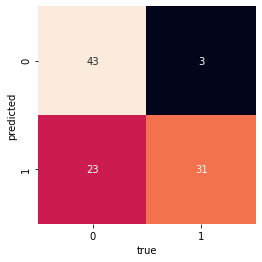

In [39]:
plot_confusion(y_test, pred)
plt.show()

### Tune model: testing 'alpha' hyper parameter

In [40]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.78

Alpha:  0.1
Score:  0.87

Alpha:  0.2
Score:  0.81

Alpha:  0.30000000000000004
Score:  0.8

Alpha:  0.4
Score:  0.79

Alpha:  0.5
Score:  0.76

Alpha:  0.6000000000000001
Score:  0.75

Alpha:  0.7000000000000001
Score:  0.76

Alpha:  0.8
Score:  0.74

Alpha:  0.9
Score:  0.74



/opt/anaconda3/envs/mimicnlp/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
